This notebook illustrates how the initial default parameter setting of ``min_conservation=0.40`` for ``q2_alignment.mask``. **This analysis is a stopgap to get us a reasonable starting value for this.** From here, we plan to explore how ``min_conservation`` impacts the trees that result from this process. 

This notebook uses private aspects of the API, so is not guaranteed to work with future versions (but you can always access the commit where this notebook was last modified - the code here should work with that commit).

Our goal here was to find the highest value of ``min_conservation`` that seems to reproduce the Lane mask based on the Greegenes 13_8 OTUs alignments. We compute conservations based on the Greengenes alignments, and then indicate which positions would be retained (getting a value of ``1``) or excluded (getting a value of ``0``) for a range of values ``min_conservation``, which we represent in a binary mask. We then compare each of these binary masks to the Lane mask, to see what fraction of positions are identical. 

# Prepare the analysis

* Load the Lane mask from QIIME default reference 
* Define functions that will be used
* Compare masks for a range of min_conservation values and for all of the reference OTU alignments to the Lane mask
* Load the results into a ``pandas.DataFrame``

In [57]:
import skbio
import numpy as np
import qiime_default_reference
from q2_alignment._filter import _compute_conservation_mask, _compute_frequencies

lane_mask = [i == '1' for i in qiime_default_reference.get_template_alignment_column_mask().decode()]
print(qiime_default_reference.__version__)

0.1.3


In [11]:
def compare_masks(mask1, mask2):
    if len(mask1) != len(mask2):
        raise ValueError('Only masks of equal length can be compared.')
    matches = sum(np.array(mask1) == np.array(mask2))
    return matches / len(mask1)

def compute_and_compare_masks(alignment_path, lane_mask):
    alignment = skbio.TabularMSA.read(alignment_path, constructor=skbio.DNA, lowercase=True)
    frequencies = _compute_frequencies(alignment)
    result = {}
    for c in np.arange(0.0, 1.01, 0.05):
        mask = _compute_conservation_mask(frequencies, skbio.DNA, c)
        result[c] = compare_masks(mask, lane_mask)
    return result

In [22]:
import glob
import os
alignment_paths = glob.glob("/Users/caporaso/data/gg_13_8_otus/rep_set_aligned/*_otus.fasta")

In [23]:
data = {}
for alignment_path in alignment_paths:
    percent_id = int(os.path.split(alignment_path)[1][:2])
    data[percent_id] = compute_and_compare_masks(alignment_path, lane_mask)

In [39]:
import pandas as pd
df = pd.DataFrame(data)

# Analyze results

* Visualize data in a heatmap
* Write data to file
* Test for correlation between referece OTU percent identities (this can take a long time to compute, so this suggests that the 61% OTUs are a reasonable proxy for the 99% OTUs). 

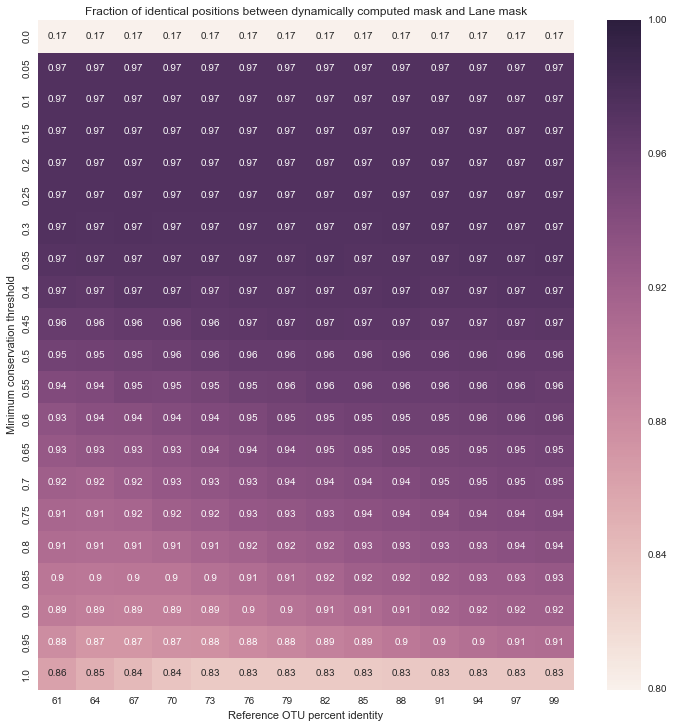

In [60]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches((12, 12))
sns.heatmap(df, vmin=0.80, vmax=1.0, annot=True, ax=ax)
ax.set_xlabel('Reference OTU percent identity')
ax.set_ylabel('Minimum conservation threshold')
ax.set_title('Fraction of identical positions between dynamically computed mask and Lane mask')


In [26]:
df.to_csv('mask_match_summary.csv')

In [28]:
df.corr()

,61,64,67,70,73,76,79,82,85,88,91,94,97,99
61,1.000000,0.999838,0.999595,0.999132,0.998696,0.998412,0.998059,0.997802,0.997422,0.997051,0.996721,0.996312,0.996023,0.995873
64,0.999838,1.000000,0.999915,0.999620,0.999284,0.998992,0.998632,0.998334,0.997920,0.997502,0.997123,0.996689,0.996383,0.996228
67,0.999595,0.999915,1.000000,0.999863,0.999626,0.999386,0.999051,0.998765,0.998350,0.997934,0.997562,0.997145,0.996854,0.996689
70,0.999132,0.999620,0.999863,1.000000,0.999920,0.999775,0.999521,0.999278,0.998919,0.998559,0.998237,0.997872,0.997624,0.997476
73,0.998696,0.999284,0.999626,0.999920,1.000000,0.999952,0.999799,0.999614,0.999334,0.999025,0.998739,0.998419,0.998200,0.998073
76,0.998412,0.998992,0.999386,0.999775,0.999952,1.000000,0.999939,0.999828,0.999622,0.999378,0.999147,0.998883,0.998701,0.998589
79,0.998059,0.998632,0.999051,0.999521,0.999799,0.999939,1.000000,0.999967,0.999858,0.999693,0.999518,0.999313,0.999167,0.999079
82,0.997802,0.998334,0.998765,0.999278,0.999614,0.999828,0.999967,1.000000,0.999956,0.999851,0.999724,0.999567,0.999449,0.999376
85,0.997422,0.997920,0.998350,0.998919,0.999334,0.999622,0.999858,0.999956,1.000000,0.999964,0.999888,0.999780,0.999692,0.999640
88,0.997051,0.997502,0.997934,0.998559,0.999025,0.999378,0.999693,0.999851,0.999964,1.000000,0.999976,0.999914,0.999856,0.999819
